In [1]:
import pandas as pd, numpy as np

In [2]:
url = r"https://docs.google.com/feeds/download/spreadsheets/Export?key=1lno5jxhFhtkk2o32gizPal9vodchQ8xT_dM3hmQOvoE&exportFormat=csv&gid=0"
data = pd.read_csv(url)

## Preparacion de la base

In [3]:
#Subset
del data["Promedio mensual"]
del data["Total"]
del data["Percapita mensual en toneladas"]

#Long Format
datal = data.melt(id_vars = ["Año", "Población"])

# Time Serie
esp = list(data.columns[1:13])
eng = []
for i in range(0,13):
    a = pd.Period(freq='D', year=2001, month=i, day=1)
    eng.append(a.strftime('%b'))

mapping = {z[0]:z[1] for z in zip(esp, eng[1:])}

datal["variable"] = datal["variable"].map(mapping)

datal.index = pd.to_datetime(
datal["Año"].astype(str) + datal["variable"], format='%Y%b'
)

del datal["Año"]
del datal["variable"]

# Value cleaning
datal = datal.rename(columns = {"value":"Cant_Residuos"})
mask = datal.Cant_Residuos == "-"
datal.loc[mask, "Cant_Residuos"] = np.nan
datal.Cant_Residuos = datal.Cant_Residuos.astype(float) * 1000
datal.Población = datal.Población.str.replace(".", "").astype(int)

In [4]:
datal = datal.fillna(method="ffill")

In [9]:
# Cantidad de Camiones
# tons_camion = capacity * compact_ratio 
tons_camion = (10.4636*900*0.453/907.185)

In [11]:
datal["Cantidad Camiones"] = datal["Cant_Residuos"] / tons_camion

## Cantidad de Camiones per cápita

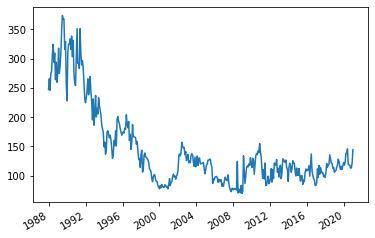

In [17]:
caiones_per_capita = datal["Población"] / datal["Cantidad Camiones"]
caiones_per_capita.plot()

## Cantidad de Residuos Mensual

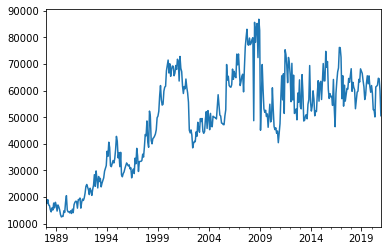

In [14]:
# Statistics
datal.resample("M").Cant_Residuos.sum().plot()

In [15]:
data_exp = datal.copy()
data_exp["Months"] = datal.index.month
data_exp = pd.get_dummies(data = data_exp,columns = ["Months"])

In [27]:
data_exp["t"] = range(0, data_exp.shape[0])

In [30]:
import statsmodels.api as sm
# data_exp
# X = 
sel = data_exp.columns.str.contains("Month")
sel[0] = True
sel[len(sel)-2] = False
sel[len(sel)-1] = True

In [31]:
X = data_exp.iloc[:,sel]
y = data_exp.Cant_Residuos

In [32]:
model = sm.OLS(y, X).fit()
# model.summary()

In [33]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          Cant_Residuos   R-squared (uncentered):                   0.933
Model:                            OLS   Adj. R-squared (uncentered):              0.931
Method:                 Least Squares   F-statistic:                              409.5
Date:                Wed, 03 Mar 2021   Prob (F-statistic):                   2.06e-215
Time:                        11:03:33   Log-Likelihood:                         -4327.6
No. Observations:                 396   AIC:                                      8681.
Df Residuals:                     383   BIC:                                      8733.
Df Model:                          13                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Población      0.1000      0.007     15.061      0.000       0.087       0.113
Months_1   -7.264e+04   8377.577     -8.671      0.000   -8.91e+04   -5.62e+04
Months_2   -7.106e+04   7670.834     -9.263      0.000   -8.61e+04    -5.6e+04
Months_3   -6.112e+04   6978.463     -8.759      0.000   -7.48e+04   -4.74e+04
Months_4   -5.554e+04   6305.199     -8.808      0.000   -6.79e+04   -4.31e+04
Months_5   -5.033e+04   5657.868     -8.895      0.000   -6.15e+04   -3.92e+04
Months_6   -4.813e+04   5046.460     -9.538      0.000   -5.81e+04   -3.82e+04
Months_7   -3.844e+04   4485.686     -8.569      0.000   -4.73e+04   -2.96e+04
Months_8   -3.139e+04   3996.917     -7.853      0.000   -3.92e+04   -2.35e+04
Months_9    -2.46e+04   3609.524     -6.816      0.000   -3.17e+04   -1.75e+04
Months_10  -1.555e+04   3358.768     -4.630      0.000   -2.22e+04   -8948.773
Months_11  -1.067e+04   3276.176     -3.257      0.001   -1.71e+04   -4229.265
t           -190.2568     23.466     -8.108      0.000    -236.396    -144.118
==============================================================================
Omnibus:                       17.933   Durbin-Watson:                   0.730
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               19.070
Skew:                           0.517   Prob(JB):                     7.23e-05
Kurtosis:                       2.703   Cond. No.                     3.06e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.06e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""